In [2]:
import numpy as np
import mesh_to_sdf as mts
import trimesh
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def get_training_data(mesh_path: str, point_count: int):
    uniform_point_count = point_count // 2
    surface_point_count = point_count // 2

    # SDF computation parameters.
    surface_point_method = "scan"
    scan_count = 100
    scan_resolution = 400
    sample_point_count = 10000000
    sign_method = "depth"
    normal_sample_count = 11
    min_size = 0.0
    return_gradients = False

    # Load the mesh and scale it so it fits into unit sphere.
    mesh = trimesh.load(mesh_path)
    mesh = mts.scale_to_unit_sphere(mesh)

    # Get SDF for points near the mesh surface and uniform points in the unit cube.
    surface_point_cloud = mts.get_surface_point_cloud(
        mesh,
        surface_point_method,
        1,
        scan_count,
        scan_resolution,
        sample_point_count,
        sign_method == "normal",
    )
    points_surface, sdf_surface = surface_point_cloud.sample_sdf_near_surface(
        surface_point_count,
        surface_point_method == "scan",
        sign_method,
        normal_sample_count,
        min_size,
        return_gradients,
    )
    points_uniform = np.random.uniform(-1, 1, size=(uniform_point_count, 3))
    sdf_uniform = surface_point_cloud.get_sdf_in_batches(
        points_uniform,
        use_depth_buffer=sign_method == "depth",
        sample_count=normal_sample_count,
        return_gradients=return_gradients,
    )

    # Merge uniform and near-surface points and sdfs.
    points = np.concatenate([points_surface, points_uniform], axis=0)
    sdf = np.concatenate([sdf_surface, sdf_uniform], axis=0)

    return points, sdf

In [4]:
points, dists = get_training_data("monkj.obj", 2000000)
points, dists = points/2., dists/2.
print(points.min(), points.max(), points.shape)
print(dists.min(), dists.max(), dists.shape)

-0.49999955140504415 0.49999995687003684 (2000000, 3)
-0.21733527 0.59056395 (2000000,)


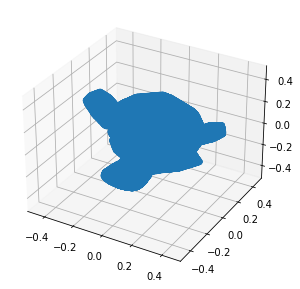

In [5]:
fig =plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)
result = points[dists<0]
ax.scatter(result[:, 0], result[:, 1], result[:, 2]*-1)

In [6]:
def FTransform(v, f, simulate_luts=False):
    x = np.dot(2 * np.pi * v, f).astype('float32')
    if simulate_luts:
        x = np.fmod(x, 2 * np.pi)
        x = np.round(x, 2)
    sin = np.sin(x)
    cos = np.cos(x)
    return np.concatenate([sin, cos], axis=-1)

In [7]:
def FF(v, N=32):
    f = np.random.normal(0.0, 3.0, size=(v.shape[1], N//2)).astype('float32')
    print(v.shape, f.shape)
    ff = FTransform(v, f)
    return ff, f

In [8]:
ff, f = FF(points)
print(ff.shape)

(2000000, 3) (3, 16)
(2000000, 32)


In [9]:
print(ff.min(), ff.max())

-1.0 1.0


In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(None,32)))
for i in range(2):
    model.add(tf.keras.layers.Dense(16, activation='relu'))

model.add(tf.keras.layers.Dense(1))
initial_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule, decay=0.1)
model.compile(optimizer=adam, loss='MSE', metrics=['MSE'])

In [17]:
model.fit(ff, dists, batch_size=2048, epochs=1200)

Epoch 1/1200
977/977 [==============================] - 1s 862us/step - loss: 0.0068 - MSE: 0.0068
Epoch 2/1200
977/977 [==============================] - 1s 853us/step - loss: 0.0020 - MSE: 0.0020
Epoch 3/1200
977/977 [==============================] - 1s 855us/step - loss: 0.0016 - MSE: 0.0016
Epoch 4/1200
977/977 [==============================] - 1s 850us/step - loss: 0.0013 - MSE: 0.0013
Epoch 5/1200
977/977 [==============================] - 1s 850us/step - loss: 0.0012 - MSE: 0.0012
Epoch 6/1200
977/977 [==============================] - 1s 866us/step - loss: 0.0012 - MSE: 0.0012
Epoch 7/1200
977/977 [==============================] - 1s 846us/step - loss: 0.0011 - MSE: 0.0011
Epoch 8/1200
977/977 [==============================] - 1s 844us/step - loss: 0.0011 - MSE: 0.0011
Epoch 9/1200
977/977 [==============================] - 1s 851us/step - loss: 0.0011 - MSE: 0.0011
Epoch 10/1200
977/977 [==============================] - 1s 851us/step - loss: 0.0011 - MSE: 0.0011
Epoch 11/

KeyboardInterrupt: 

In [18]:
RESOLUTION = 64
points_pred = np.array(np.mgrid[-0.5:0.5:RESOLUTION*1j,
                           -0.5:0.5:RESOLUTION*1j,
                           -0.5:0.5:RESOLUTION*1j]).T.reshape(-1,3)
print(points_pred.shape)

(262144, 3)


In [19]:
dists_pred = model.predict(FTransform(points_pred, f), batch_size=2048)
dists_pred.shape
print(dists_pred.min(), dists_pred.max(), dists_pred.shape)

-0.20680593 0.56416273 (262144, 1)


In [20]:
print(dists_pred.min(), dists_pred.max())

-0.20680593 0.56416273


In [21]:
inside = dists_pred < 0
inside.shape
print(np.unique(inside, return_counts=True))

(array([False,  True]), array([241400,  20744], dtype=int64))


(262144, 3) (20744, 3)


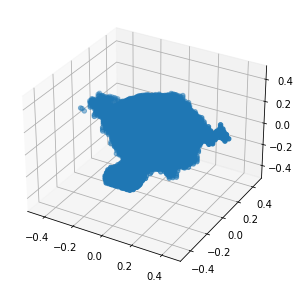

In [22]:
fig =plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)
result = points_pred[inside.reshape(-1)]
print(points_pred.shape, result.shape)
ax.scatter(result[:, 0], result[:, 1], result[:, 2]*-1)